# Clustering of Credit Card User  

My main task is to cluster credit card users into different groups and see if I can find any meaningful patterns. I will use Principal Component Analysis **(PCA)** to reduce the dimension of the feature space and then use the **K-means** algorithm to find clusters.

In [2]:
#import all the necessary library 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
CCData = pd.read_csv("E:\Downloads\CC GENERAL.csv")

In [4]:
print("Rows: ",CCData.shape[0])
print("Columns: ",CCData.shape[1])

Rows:  8950
Columns:  18


## Preprocessing the Dataset

### First Look

There are 8950 rows and 18 attributes in each row. Since this is an unsupervised learning problem, we do not have a response variable. Moreover, note that **CUST_ID** can be removed as its sole purpose is to be a primary key.

After important attributes have been identified through PCA, we will explain them in detail. We do not need to breakdown every single attribute because we will not be using every single attribute.

In [6]:
CCData = CCData.drop("CUST_ID", axis = 1)

### Missing Values

Next, we look for missing values and handle them accordingly.

In [7]:
CCData.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

We see that there is one NULL value for **CREDIT_LIMIT** and 313 NULL values for **MINIMUM_PAYMENTS**. Before we fill in the NULL values, we need to understand what these attributes are doing.
1. When **MINIMUM_PAYMENTS** is null, it is safe to assume that no minimum payment was made. This means we can convert all the NULL values in **MINIMUM_PAYMENTS** to 0.  


2. When **MINIMUM_PAYMENTS** is NULL, the most rational assumption is that there is no credit limit for that particular customer. Once again, we can set it to 0.

In [8]:
CCData=CCData.fillna(0)

### Standardize and Normalize

Before we perform PCA, we standardize and normalize the data. Moreover, since the clustering algorithm is based on distance between data points, large magnitudes could adversely impact the outcome.  

In [13]:
scaler= StandardScaler()
scaled_CCData=scaler.fit_transform(CCData)
norm_CCData= normalize(scaled_CCData)

## PCA

We use PCA to reduce the dimensionality of our data. Essentially, we are reducing our 17 dimensional data to n dimensions - where n is the number of components. Since clustering methods suffer from the "curse of dimensionality," we make our data less complex.

In [14]:
pca= PCA()
pca.fit(norm_CCData)

PCA()

Text(0, 0.5, 'Cumulative explained variance')

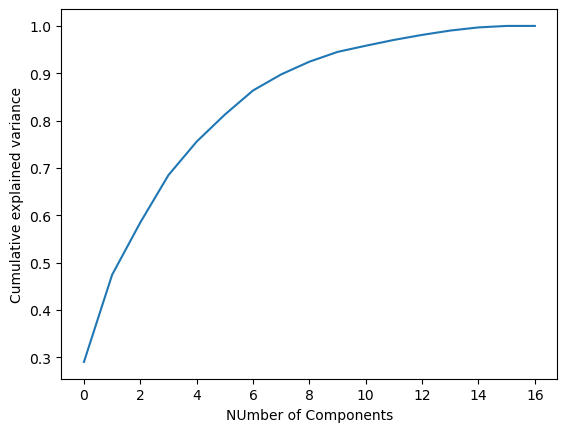

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("NUmber of Components")
plt.ylabel("Cumulative explained variance")

In [17]:
np.cumsum(pca.explained_variance_ratio_)

array([0.29044997, 0.47452947, 0.58490237, 0.68505818, 0.75571567,
       0.8127604 , 0.86368729, 0.89770753, 0.92447857, 0.94517107,
       0.95813186, 0.97045662, 0.9810481 , 0.99022739, 0.99688251,
       0.9999988 , 1.        ])

### PCA Summary

The above plot shows us the total explained variance for the number of principal components we use. For our case, we will use 2 principal components. The first 2 principal components explain **47.5%** of the variation in data. While 4 or 5 components would be ideal in terms of explaining variance, we pick 2 so that we can visualize the clustering as well. 

In [18]:
n_components=2
pca_final= PCA(n_components=n_components)
pca_final.fit(norm_CCData)
pca_CCData= pca_final.fit_transform(norm_CCData)

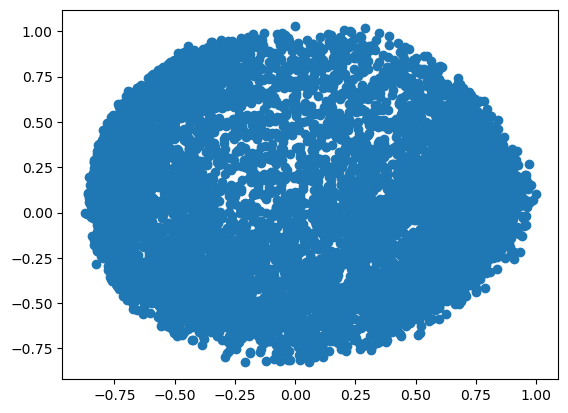

In [21]:
plt.scatter(pca_CCData[:,0],pca_CCData[:,1])
plt.show()

### Visualize Reduced Data

When we look at the data, there are no immediate patterns jumping out at us. Next, we try interpret these principal components.

In [25]:
for i in np.arange(n_components):
    index= np.argmax(np.absolute(pca_final.get_covariance()[i]))
    max_cov = pca_final.get_covariance()[i][index]
    column = CCData.columns[index]
    print("Principal Components", i+1, "maximum Covariance :", "{:.2f}".format(max_cov), "from column", column)

Principal Components 1 maximum Covariance : 0.06 from column BALANCE
Principal Components 2 maximum Covariance : 0.04 from column BALANCE_FREQUENCY


### Interpret PCA

Since the principal components are linear combinations of the attributes, we are basically trying to identify which variables  affect the principal components the most. More specifically, we look at the covariance matrix to see which attribute has the most covariance with the principal component.

1. For the first principal component, the **BALANCE** column has the most covariance. We could think of the first principal component as being representative of **BALANCE**. The **BALANCE** refers to the balance left in the customer's account to make purchases.  


2. For the second principal component, the **BALANCE_FREQUENCY** column has the most covariance. Loosely speaking, the second principal component is representative of the **BALANCE_FREQUENCY**. The **BALANCE_FREQUENCY** tells us how often ther customer's balance is updated.

## Kmeans Clustering

Recall that in order to use the Kmeans algorithm, we have to provide the number of clusters that we are trying to segment our data into. Since we do not know what is ideal, let us try a range of 2-11 clusters. We will look at metric plots to determine what works best.

### Interpret PCA

Since the principal components are linear combinations of the attributes, we are basically trying to identify which variables  affect the principal components the most. More specifically, we look at the covariance matrix to see which attribute has the most covariance with the principal component.

1. For the first principal component, the **BALANCE** column has the most covariance. We could think of the first principal component as being representative of **BALANCE**. The **BALANCE** refers to the balance left in the customer's account to make purchases.  


2. For the second principal component, the **BALANCE_FREQUENCY** column has the most covariance. Loosely speaking, the second principal component is representative of the **BALANCE_FREQUENCY**. The **BALANCE_FREQUENCY** tells us how often ther customer's balance is updated.

## Kmeans Clustering

Recall that in order to use the Kmeans algorithm, we have to provide the number of clusters that we are trying to segment our data into. Since we do not know what is ideal, let us try a range of 2-11 clusters. We will look at metric plots to determine what works best.

In [26]:
sse = {}
n_clust = np.arange(2,11)

for i in n_clust:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(pca_CCData)
    sse[i] = kmeans.inertia_

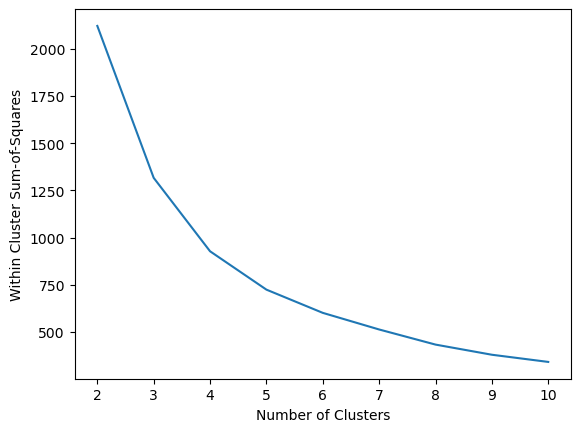

In [27]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Within Cluster Sum-of-Squares")
plt.show()

### Summary of Kmeans

In the above plot, we are looking for an "elbow." The elbow tells us the point where increasing the number of variables does not yield a significant decrease in inertia. The inertia here is referring to within cluster sum of squares. It tells how compact a given cluster is. From the above plot, 3 clusters seem sufficient. Although using 10 clusters gives us the least inertia, it will be very difficult to interpret and may not have significant meaning. 

In [28]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(pca_CCData)

KMeans(n_clusters=3, random_state=0)

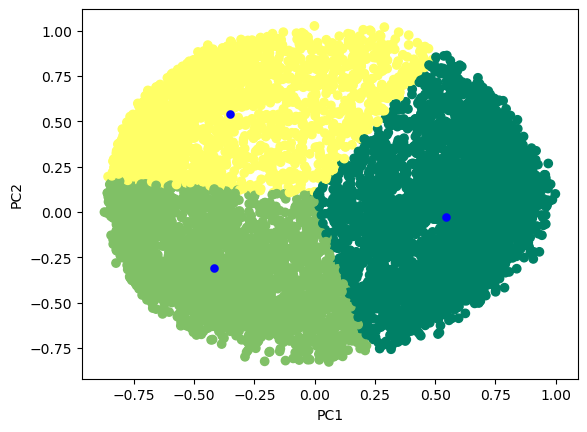

In [30]:
plt.scatter(pca_CCData[:,0], pca_CCData[:,1],
            c = KMeans(n_clusters = 3).fit_predict(pca_CCData),
            cmap = plt.cm.summer)
centroids = kmeans.cluster_centers_

plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='o', s=10, linewidths=3,
            color='b', zorder=10)

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show() 